# Deconvolution: Flow-Matching

In [9]:
from DynGenModels.datamodules.toys.configs import Gauss_Deconv_Configs
from DynGenModels.models.configs import MLP_Configs
from DynGenModels.dynamics.cnf.configs import CNF_Configs
from DynGenModels.pipelines.configs import NeuralODE_Sampler_Configs

Configs = DynGenModelConfigs(data = Gauss_Deconv_Configs,
                             model = MLP_Configs, 
                             dynamics = CNF_Configs, 
                             pipeline = NeuralODE_Sampler_Configs)

configs = Configs(data_name = 'smeared_gaussians',
                features = ['x', 'y'],
                num_points = 30000,
                sigma = 1e-6,
                noise_cov = [[0.1,0],[0,1]],
                data_split_fracs = [0.6, 0.1, 0.3],
                epochs = 300,
                early_stopping=1000,
                batch_size = 512,
                warmup_epochs = 50,
                print_epochs = 50,
                lr = 1e-3,
                dim_hidden = 16, 
                device = 'cpu',
                solver='midpoint',
                num_sampling_steps=1000,
                seed = 12345
                )
                
configs.set_workdir(path='../results', save_config=True)

#=============================================================================
INFO: created directory: ../results/MLP.smeared_gaussians_2023.09.28_19h24__1
#=============================================================================
+--------------------+--------------------+
| Key                | Value              |
+--------------------+--------------------+
| features           | ['x', 'y']         |
| data_name          | smeared_gaussians  |
| num_points         | 30000              |
| dim_input          | 2                  |
| noise_cov          | [[0.1, 0], [0, 1]] |
| device             | cpu                |
| data_split_fracs   | [0.6, 0.1, 0.3]    |
| batch_size         | 512                |
| epochs             | 300                |
| early_stopping     | 1000               |
| warmup_epochs      | 50                 |
| print_epochs       | 50                 |
| lr                 | 0.001              |
| seed               | 12345              |
| model_name    

In [10]:
from DynGenModels.datamodules.toys.datasets import SmearedGaussDataset as DataSet
from DynGenModels.datamodules.toys.dataloader import ToysDataLoader as Loader

dataset = DataSet(configs)
dataloader = Loader(dataset, configs)

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.6/0.1/0.3
INFO: train size: 18000, validation size: 3000, testing sizes: 9000


In [11]:
from DynGenModels.models.mlp import MLP
from DynGenModels.dynamics.cnf.deconvolution import DeconvolutionFlowMatching

mlp = MLP(configs)
cfm = DynGenModelTrainer(dynamics=DeconvolutionFlowMatching(mlp, configs), 
                         dataloader=dataloader,
                         configs=configs)

cfm.train()

INFO: number of training parameters: 642


epochs:   0%|          | 0/300 [00:00<?, ?it/s]

	 test loss: 0.0010236703157424927  (min loss: 0.0010236703157424927)
	 test loss: 0.000908848524093628  (min loss: 0.0008689931432406108)
	 test loss: 0.0008907763659954071  (min loss: 0.0008394133150577545)
	 test loss: 0.0008553609748681387  (min loss: 0.0008394133150577545)
	 test loss: 0.0009241629143555959  (min loss: 0.0008394133150577545)
	 test loss: 0.0009147012333075205  (min loss: 0.0008394133150577545)


sampling pipeline:

In [15]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline as Pipeline
pipeline = Pipeline(trained_model=cfm, configs=configs, num_sampling_steps=200)

sampling:   0%|          | 0/18 [00:00<?, ?it/s]

/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


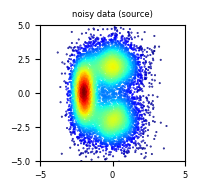

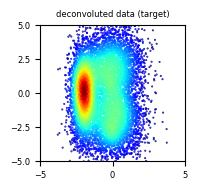

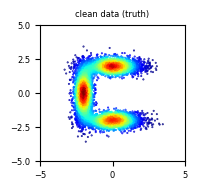

In [16]:

def plot_gaussians(data, num_points=None, title=None):

    import scipy.stats as stats

    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()


plot_gaussians(dataset.source, title='noisy data (source)', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='deconvoluted data (target)')
plot_gaussians(dataset.truth, title='clean data (truth)', num_points=len(pipeline.target))

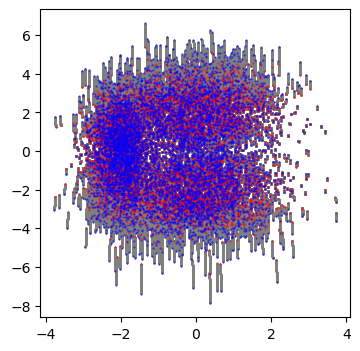

In [17]:
#...plot trajectories:

num_points =10000
fig, ax = plt.subplots(1,1, figsize=(4,4))
for i in range(configs.num_sampling_steps): 
    plt.scatter(pipeline.trajectories[i][:num_points,0], pipeline.trajectories[i][:num_points,1], s=0.0225, color='gray', alpha=0.3)
plt.scatter(pipeline.trajectories[0][:num_points,0], pipeline.trajectories[0][:num_points,1], s=0.3, color='red', alpha=0.6)
plt.scatter(pipeline.trajectories[-1][:num_points,0], pipeline.trajectories[-1][:num_points,1], s=0.3, color='blue', alpha=0.6)
plt.show()

# Deconvolution Normalizing Flows

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from DynGenModels.configs.utils import DynGenModelConfigs
from DynGenModels.trainer.trainer import DynGenModelTrainer

In [6]:
from DynGenModels.datamodules.toys.configs import Gauss_Deconv_Configs
from DynGenModels.models.configs import MAF_RQS_Configs
from DynGenModels.dynamics.nf.configs import Deconvolution_NormFlow_Configs
from DynGenModels.pipelines.configs import NormFlows_Sampler_Configs

Configs = DynGenModelConfigs(data = Gauss_Deconv_Configs,
                             model = MAF_RQS_Configs, 
                             dynamics = Deconvolution_NormFlow_Configs, 
                             pipeline = NormFlows_Sampler_Configs)

configs = Configs(data_name = 'smeared_gaussians',
                features = ['x', 'y'],
                num_points = 30000,
                noise_cov = [[0.1,0],[0,1]],
                data_split_fracs = [0.8, 0.19, 0.01],
                epochs = 10,
                early_stopping=30,
                batch_size = 256,
                warmup_epochs = 20,
                print_epochs = 10,
                lr = 5e-4,
                dim_hidden = 128, 
                device = 'cpu',
                seed = 12345,
                num_transforms = 2,
                num_gen_samples = 6000,
                num_mc_draws = 30
                )

configs.set_workdir(path='../results', save_config=True)

#=================================================================================
INFO: created directory: ../results/MAF_RQS.smeared_gaussians_2023.09.28_23h00__1
#=================================================================================
+---------------------+--------------------+
| Key                 | Value              |
+---------------------+--------------------+
| features            | ['x', 'y']         |
| data_name           | smeared_gaussians  |
| num_points          | 30000              |
| dim_input           | 2                  |
| noise_cov           | [[0.1, 0], [0, 1]] |
| device              | cpu                |
| data_split_fracs    | [0.8, 0.19, 0.01]  |
| batch_size          | 256                |
| epochs              | 10                 |
| early_stopping      | 30                 |
| warmup_epochs       | 20                 |
| print_epochs        | 10                 |
| lr                  | 0.0005             |
| seed                | 12345   

In [7]:
from DynGenModels.datamodules.toys.datasets import SmearedGaussDataset
from DynGenModels.datamodules.toys.dataloader import ToysDataLoader

dataset = SmearedGaussDataset(configs)
dataloader = ToysDataLoader(dataset, configs)

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.19/0.01
INFO: train size: 24000, validation size: 5700, testing sizes: 300


In [8]:
from DynGenModels.dynamics.nf.deconvolution import DeconvolutionNormFlows
from DynGenModels.models.maf import  MAFPiecewiseRQS

maf = MAFPiecewiseRQS(configs)
nflow = DynGenModelTrainer(dynamics=DeconvolutionNormFlows(maf, configs), 
                           dataloader=dataloader,
                           configs=configs)

nflow.train()

INFO: number of training parameters: 40890


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

	 test loss: 0.0011815134788814344  (min loss: 0.0011815134788814344)


In [9]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline
pipeline = NormFlowPipeline(trained_model=nflow, configs=configs, num_gen_samples=6000)

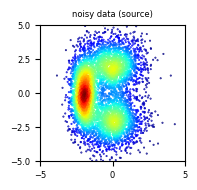

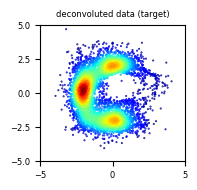

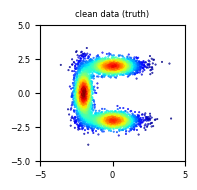

In [11]:

def plot_gaussians(data, num_points=None, title=None):

    import scipy.stats as stats

    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()


plot_gaussians(dataset.source, title='noisy data (source)', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='deconvoluted data (target)')
plot_gaussians(dataset.truth, title='clean data (truth)', num_points=len(pipeline.target))